In [1]:
import pandas as pd

In [2]:
#Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
query = """
SELECT *,
CASE WHEN canales = 2 THEN 'ON-OFF'
WHEN canales = 1 AND tipo_pedido = 'ONLINE' THEN 'ONLINE'
WHEN canales = 1 AND tipo_pedido = 'OFFLINE' THEN 'OFFLINE'
END tipo_pedido
FROM (
SELECT Telefono, AVG(dias_compra) promedio, stddev(dias_compra) des, COUNT(DISTINCT TIPO_PEDIDO_BIEN) canales, MAX(TIPO_PEDIDO_BIEN) tipo_pedido FROM (  

SELECT *, 
DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) dias_compra FROM (
SELECT * , 
CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END as TA,-- PEDIDOS TEMPORADA ALTA
CASE 
--WHEN (mobile IS NOT NULL AND mobile != '000000000') AND customerNoIfOffline IS NOT NULL THEN mobile
--WHEN (mobile IS NOT NULL AND mobile = '000000000') AND customerNoIfOffline IS NOT NULL THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
ELSE mobile END AS Telefono,

FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier`
WHERE CAST(createdAt as DATE) >= DATE_SUB(DATE('2020-01-31'), INTERVAL 365 DAY) --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
AND status = 'COMPLETED'  --ESTADO DE PEDIDO COMPLETADO
AND isAnulled IS NULL     --PEDIDO NO ANULADO
--AND mobile IS NOT NULL    --TELEFONO NO NULO
AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE'))
)

GROUP BY Telefono 
)

"""
#project_id = 'gasco-analytics'
#Clientes = pd.read_gbq(query, project_id = project_id)
#Clientes.head()

In [4]:
query_job = client.query(query)  # API request
#rows = query_job.result()  # Waits for query to finish
df_transaccional = query_job.to_dataframe()
df_transaccional.head(5)

,Telefono,promedio,des,canales,tipo_pedido,tipo_pedido_1
0,931168895,49.555556,39.240002,2,ONLINE,ON-OFF
1,945513845,107.000000,82.891495,2,ONLINE,ON-OFF
2,965810178,10.063492,11.595151,2,ONLINE,ON-OFF
3,975672249,46.666667,20.428738,2,ONLINE,ON-OFF
4,989850862,29.250000,17.173138,2,ONLINE,ON-OFF


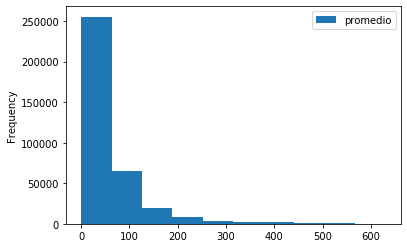

In [5]:
Clientes[['promedio']].plot.hist()

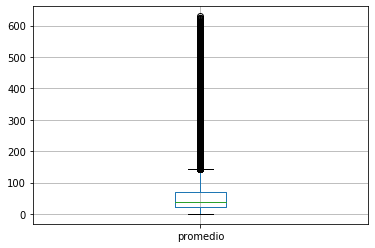

In [6]:
Clientes[['promedio']].boxplot()

In [9]:
print(Clientes.shape[0])
Clientes[['promedio']].isna().sum()

711651


promedio    352780
dtype: int64

De un total de 711651 telefonos unicos que han comprado envasado (Linea 800 y Gasconnect) durante el ultimo año, un total de 352780 corresponde a clientes que han comprado una sola vez.

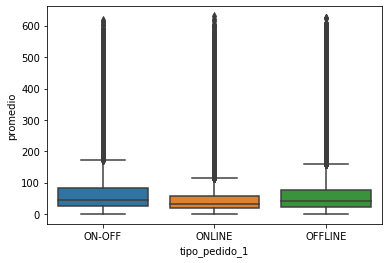

In [14]:
import seaborn as sns
sns.boxplot(y = 'promedio',x = 'tipo_pedido_1', data = Clientes)

In [16]:
query = """

SELECT Telefono, primera_compra, ultima_compra, pedidos, recencia, canales, TIPO_PEDIDO_BIEN as ult_canal
FROM `gasco-analytics.gasco.Clasificacion_Clientes`
WHERE CAST(ultima_compra as DATE) >= DATE_SUB(DATE('2020-01-31'), INTERVAL 365 DAY) --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
"""
project_id = 'gasco-analytics'
clasificacion = pd.read_gbq(query, project_id = project_id)
clasificacion.head()


Downloading: 100%|█████████████████████████████████████████████████████████| 711651/711651 [01:16<00:00, 9256.20rows/s]


,Telefono,primera_compra,ultima_compra,pedidos,recencia,canales,ult_canal
0,976888880,2019-06-23,2020-02-14,19,256,1,ONLINE
1,973012156,2018-03-25,2020-02-14,15,256,1,OFFLINE
2,962010980,2018-10-25,2020-02-14,19,256,1,ONLINE
3,227435226,2017-10-22,2020-02-14,20,256,1,OFFLINE
4,999178262,2018-02-16,2020-02-14,22,256,1,ONLINE


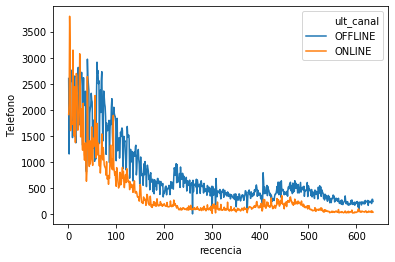

In [19]:
a = clasificacion.groupby(['recencia','ult_canal']).count().reset_index()
sns.lineplot( x = 'recencia', y = 'Telefono', data = a, hue = 'ult_canal')

In [21]:
full = Clientes.merge(clasificacion, on = 'Telefono', how = 'inner')
full.head(5)

,Telefono,promedio,des,canales_x,tipo_pedido,tipo_pedido_1,primera_compra,ultima_compra,pedidos,recencia,canales_y,ult_canal
0,935054698,157.0000,181.019336,2,ONLINE,ON-OFF,2019-09-16,2020-07-26,3,93,2,ONLINE
1,946272711,4.4375,20.009348,2,ONLINE,ON-OFF,2019-03-21,2020-10-09,129,18,2,ONLINE
2,947800718,14.3750,12.304906,2,ONLINE,ON-OFF,2020-06-12,2020-10-05,9,22,2,OFFLINE
3,954120111,167.5000,207.182287,2,ONLINE,ON-OFF,2019-07-31,2020-06-30,3,119,2,OFFLINE
4,991287607,589.0000,NaN,2,ONLINE,ON-OFF,2018-12-16,2020-09-17,3,40,2,ONLINE


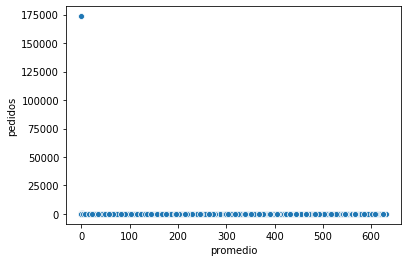

In [22]:
sns.scatterplot(x = 'promedio', y ='pedidos', data = full)

In [24]:
full[full['pedidos'] >150]

,Telefono,promedio,des,canales_x,tipo_pedido,tipo_pedido_1,primera_compra,ultima_compra,pedidos,recencia,canales_y,ult_canal
243,958681276,3.765101,21.903470,2,ONLINE,ON-OFF,2018-12-01,2020-08-20,270,68,2,ONLINE
742,933972746,1.795222,12.174490,2,ONLINE,ON-OFF,2019-05-19,2020-10-26,294,1,2,ONLINE
800,945797466,2.075314,3.889570,2,ONLINE,ON-OFF,2019-06-16,2020-10-24,240,3,2,ONLINE
902,None,0.199508,0.512212,2,ONLINE,ON-OFF,2017-04-21,2020-08-21,173572,67,2,None
5299,977067735,2.829146,4.692672,2,ONLINE,ON-OFF,2018-09-30,2020-08-22,205,66,2,ONLINE
...,...,...,...,...,...,...,...,...,...,...,...,...
434750,226369500,3.972789,5.143084,1,OFFLINE,OFFLINE,2017-10-23,2020-09-24,179,33,1,OFFLINE
442172,582221818,0.800797,1.520579,1,OFFLINE,OFFLINE,2019-09-04,2020-03-23,252,218,1,OFFLINE
473583,226944444,0.740472,1.070164,1,OFFLINE,OFFLINE,2019-09-12,2020-10-24,552,3,1,OFFLINE
521172,512759671,1.611940,1.228274,1,OFFLINE,OFFLINE,2018-01-18,2019-12-21,461,311,1,OFFLINE


SELECT Count(1) FROM `gasco.pedidos_gasconnect_todos_javier`   WHERE mobile IS NULL AND customerNoIfOffline IS NULL AND status = 'COMPLETED' AND isAnulled IS NULL AND TIPO_PEDIDO_BIEN IN ('ONLINE', 'OFFLINE')

3340 registros sin número de teléfono